https://drive.google.com/file/d/1j1qW-rn0qnH4ExfDy2ZTvBHYnTQj_UUo/view?usp=sharing

In [ ]:
! gdown --id 1j1qW-rn0qnH4ExfDy2ZTvBHYnTQj_UUo

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1j1qW-rn0qnH4ExfDy2ZTvBHYnTQj_UUo
To: /content/internship_обработка_текста.zip
100% 78.3M/78.3M [00:01<00:00, 75.8MB/s]


In [ ]:
! unzip /content/internship_обработка_текста.zip

Archive:  /content/internship_обработка_текста.zip
  inflating: train.parquet           
  inflating: test.parquet            


ИМПОРТ НЕОБХОДИМЫХ БИБЛИОТЕК

In [ ]:
import pandas as pd
import json
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from imblearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

В ходе исследования нам может понадобиться лемматизация. Поэтому установим дополнительную библиотеку pymorphy2 для этого.

In [ ]:
%pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 57.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=874bb07815c6a1ddd7591241628e401504d75525057c6693e6b3070cf09603bc
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [ ]:
import pymorphy2

ЧТЕНИЕ ДАННЫХ

In [ ]:
data_train= pd.read_parquet("/content/train.parquet", engine='pyarrow')
data_train.head()

,product_id,category_id,sale,shop_id,shop_title,rating,text_fields,category_name
0,325286,12171,False,9031,Aksik,5.0,"{""title"": ""Зарядный кабель Borofone BX1 Lightn...",Все категории->Электроника->Смартфоны и телефо...
1,888134,14233,False,18305,Sela,5.0,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-...",Все категории->Одежда->Женская одежда->Белье и...
3,1267173,13429,False,16357,ЮНЛАНДИЯ канцтовары,5.0,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 цветов...",Все категории->Хобби и творчество->Рисование->...
4,1416943,2789,False,34666,вася-nicotine,4.0,"{""title"": ""Колба для кальяна Крафт (разные цве...",Все категории->Хобби и творчество->Товары для ...
5,1058275,12834,False,26389,Lim Market,4.6,"{""title"": ""Пижама женская, однотонная с шортам...",Все категории->Одежда->Женская одежда->Домашня...


In [ ]:
data_train.shape

(91120, 8)

Посмотрим, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, заменим их на что-то. 

In [ ]:
data_train.isna().sum() # пропущенных нет...

product_id       0
category_id      0
sale             0
shop_id          0
shop_title       0
rating           0
text_fields      0
category_name    0
dtype: int64

In [ ]:
data_train.duplicated().sum() #проверка на дублирующие строки - дубликатов нет

0

category_id - категория товара, это тот признак, которорый нам необходимо научиться предсказывать. Посмотрим сколько уникальных category_id в датасете

In [ ]:
data_train['category_id'].value_counts() 

11937    6590
14922    3709
13651    1463
13143    1460
12980    1222
         ... 
12808       2
12901       1
11549       1
11875       1
12836       1
Name: category_id, Length: 874, dtype: int64

Проще всего countplot построить с помощью библиотеки Seaborn.

<Axes: xlabel='category_id', ylabel='count'>

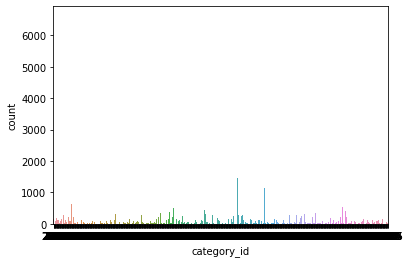

In [ ]:
sns.countplot(x = 'category_id', data = data_train)

Классы сильно несбалансированны. Необходимо удалить из исходного датасете категории, которых очень мало. Оставим примерно 95% от исходного датасета. Создадим вспомогательный датасет, с количеством каждой категории

In [ ]:
count_category_df = pd.DataFrame(data_train["category_id"].value_counts()).reset_index().rename(columns={"index": "category_id", "category_id": "counts"})
count_category_df.head()

,category_id,counts
0,11937,6590
1,14922,3709
2,13651,1463
3,13143,1460
4,12980,1222


In [ ]:
clean_data_df = data_train.loc[data_train["category_id"].isin(count_category_df[count_category_df["counts"] >= 25]["category_id"])]
clean_data_df.shape

(87093, 8)

В исходном датасете осталось 87093 товаров, что состовляет 95.5% от исходной выборки (91120 товаров)

In [ ]:
clean_data_df.head()

,product_id,category_id,sale,shop_id,shop_title,rating,text_fields,category_name
0,325286,12171,False,9031,Aksik,5.0,"{""title"": ""Зарядный кабель Borofone BX1 Lightn...",Все категории->Электроника->Смартфоны и телефо...
1,888134,14233,False,18305,Sela,5.0,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-...",Все категории->Одежда->Женская одежда->Белье и...
3,1267173,13429,False,16357,ЮНЛАНДИЯ канцтовары,5.0,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 цветов...",Все категории->Хобби и творчество->Рисование->...
5,1058275,12834,False,26389,Lim Market,4.6,"{""title"": ""Пижама женская, однотонная с шортам...",Все категории->Одежда->Женская одежда->Домашня...
7,1035042,12909,False,26110,HaL-Va,5.0,"{""title"": ""Детские теплые носки"", ""description...",Все категории->Одежда->Детская одежда->Одежда ...


В таблице осталось несколько ненужных колонок: product_id, sale, shop_id, rating, category_name (category_name и category_id по сути идентичны, поэтому оставим только category_id) нам не нужны, поскольку не влияют на предсказываемый параметр category_id, поэтому удалим их их датасета

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
clean_data_df.drop(['product_id', 'sale','shop_id', 'rating', 'category_name'], axis=1, inplace=True)
clean_data_df.head()

,category_id,shop_title,text_fields
0,12171,Aksik,"{""title"": ""Зарядный кабель Borofone BX1 Lightn..."
1,14233,Sela,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-..."
3,13429,ЮНЛАНДИЯ канцтовары,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 цветов..."
5,12834,Lim Market,"{""title"": ""Пижама женская, однотонная с шортам..."
7,12909,HaL-Va,"{""title"": ""Детские теплые носки"", ""description..."


Обработаем данные для того, чтобы к ним можно было применить различные модели машинного обучения. Основное данные о товарах содержатся в графе text_fields. Данные в формате json. Распарсим их в словарь. В этом словаре, ключи - "title","description", "attributes", "filters", "defined_characteristics", "custom_characteristics"

In [ ]:
clean_data_df["text_fields_dict"] = clean_data_df["text_fields"].apply(lambda x: json.loads(x))
clean_data_df["text_fields_dict"].head()

0    {'title': 'Зарядный кабель Borofone BX1 Lightn...
1    {'title': 'Трусы Sela', 'description': 'Трусы-...
3    {'title': 'Гуашь "ЮНЫЙ ВОЛШЕБНИК", 12 цветов п...
5    {'title': 'Пижама женская, однотонная с шортам...
7    {'title': 'Детские теплые носки', 'description...
Name: text_fields_dict, dtype: object

Напишем вспомогательную функцию bag_words - мешок слов, котороя переведет словарь в строку без какого-либо учета грамматики и порядка слов, но с сохранением информации об их количестве. 

In [ ]:
def bag_words(dict_from_df): #функция превращает исходный словарь в строку

    string = dict_from_df["title"]+" "+dict_from_df["description"]+" "+" ".join(dict_from_df["attributes"])
    if dict_from_df.get('filters'):
        string += " "+" ".join(dict_from_df['filters'].keys())
    if dict_from_df.get('defined_characteristics'):
        string += " " + " ".join(dict_from_df['defined_characteristics'].keys())
        string += " " + " ".join([" ".join(set(token)) for token in dict_from_df['defined_characteristics'].values()])
    if dict_from_df.get('custom_characteristics'):
        string += " " + " ".join(dict_from_df['custom_characteristics'].keys())
        string += " " + " ".join([" ".join(set(token)) for token in dict_from_df['custom_characteristics'].values()])

    return " ".join(string.split())
clean_data_df["bag_words"] = clean_data_df["text_fields_dict"].apply(lambda x: bag_words(x))
clean_data_df["bag_words"].head()

0    Зарядный кабель Borofone BX1 Lightning для айф...
1    Трусы Sela Трусы-слипы из эластичного бесшовно...
3    Гуашь "ЮНЫЙ ВОЛШЕБНИК", 12 цветов по 35 мл, БО...
5    Пижама женская, однотонная с шортами <p>Лёгкая...
7    Детские теплые носки <p>Детские теплые носочки...
Name: bag_words, dtype: object

Поскольку магазины могут быть специализированными, и, как следствие, могут влиять на предсказываемую категорию товаров, то их наследует добавить к общим данным 

In [ ]:
clean_data_df["full_data"] = clean_data_df["bag_words"] + " " + clean_data_df['shop_title']
clean_data_df["full_data"].head()

0    Зарядный кабель Borofone BX1 Lightning для айф...
1    Трусы Sela Трусы-слипы из эластичного бесшовно...
3    Гуашь "ЮНЫЙ ВОЛШЕБНИК", 12 цветов по 35 мл, БО...
5    Пижама женская, однотонная с шортами <p>Лёгкая...
7    Детские теплые носки <p>Детские теплые носочки...
Name: full_data, dtype: object

Напишем вспомогательные фунции - clean_data и preprocess_data, с помощью которых обработаем данные. Функция clean_data с помощью регулярных выражений уберет из текста знаки пунктуации и теги (выражения написанные между <>). Функция preprocess_data уберет стопслова, местоимения, предлоги и цыфры. Лемматизацию (преобразование слова к нормальной форме) было решено не делать, поскольку на всех тестируемых моделях она приводила к ухудшению точности (f1_score). Возможно, это связанно с тем, что склонение слов говорит многое о 
товаре. К примеру, содержание текста «для телефона» уже может говорить о том, что данный товар не телефон, а аксессуар для телефона, в то время как содержание слова «телефон» говорит, что это товар относится к категории телефоны. Если же 
нормализовать текст «для телефона», то он преобразуется в текст «для телефон», и модели будет тяжелее классифицировать товар верно

In [ ]:
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
def clean_data(line):

    tokens = str(line)
    tokens = [re.sub('<[^>]+>', '', token).strip(string.punctuation) for token in tokens.split()]
    line = " ".join(tokens)
    return line

def preprocess_data(text):

    tokens = str(text)
    tokens = [token for token in tokens.split() if token not in russian_stopwords\

              and token.isalpha()\
              and len(token)>=3 ]
    text = " ".join(tokens)
    return text

clean_data_df['preprocessed'] = clean_data_df["full_data"].apply(lambda x: clean_data(x)).apply(lambda x: preprocess_data(x))
clean_data_df['preprocessed'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    Зарядный кабель Borofone Lightning айфон span ...
1    Трусы Sela эластичного бесшовного трикотажа Од...
3    Гуашь ЮНЫЙ ВОЛШЕБНИК цветов БОЛЬШИЕ БАНОЧКИ вы...
5    Пижама женская однотонная шортами Лёгкая ткань...
7    Детские теплые носки Детские теплые носочкиПро...
Name: preprocessed, dtype: object

Поделим наш датасет на X — обработанные наименования товаров и на y — их категории. Разделим на обучающую и тестовую выборку, отдав под тесты 20% от общего числа данных.

In [ ]:
X = clean_data_df.preprocessed
y = clean_data_df.category_id
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

Для начала  в качесте классификатора выберем наивный баесовский классификатор. Создадим пайплайн со следующими командами:

CountVectorizer() — возвращает матрицу с количеством вхождений каждого токена
TfidfTransformer() — преобразует эту матрицу в нормализованное представление tf-idf
MultinomialNB() — наивный байесовский классификатор для предсказания категории товара. И поскольку классификация мультиклассовая воспользуемся OneVsRestClassifier. Обучим модель и посмотрим f1_score.

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))])

text_clf = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
print('Score:', 100*f1_score(y_test, y_pred,  average='weighted'))

Score: 44.16579307651482


Теперь попробуем SGDClassifier - один из лучших классификаторов для обработки текста 

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', OneVsRestClassifier(SGDClassifier(), n_jobs=-1))])

text_clf = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
print('Score:', 100*f1_score(y_test, y_pred,  average='weighted'))

Score: 80.57725171319287


В случае использования SGDClassifier целевой показатель (f1_score) оказался существенно выше, что говорит о том, что предсказывемый параметр линейнозависит от признаком. Попробуем использовать другие линейные модели, например, LinearSVC.

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', OneVsRestClassifier(LinearSVC(random_state=42, tol=1e-3), n_jobs=-1))])

text_clf = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
print('Score:', 100*f1_score(y_test, y_pred,  average='weighted'))

Score: 86.91048881560873


Попробуем немного настроить параметры. Параметры будем настраивал вручную поскольку GridsearchCV требует много ресурсов. Не хватает ОЗУ на гугл коллабе. 

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf=False, smooth_idf=False)),
                      ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))])
text_clf = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
print('Score:', 100*f1_score(y_test, y_pred,  average='weighted'))

Score: 86.96259320501144


Настройка параметров привела к незначительному увеличению f1_score. Считаем тестовые данные.

In [ ]:
data_test = pd.read_parquet("/content/test.parquet", engine='pyarrow')
data_test.head()


,product_id,sale,shop_id,shop_title,rating,text_fields
1,1997646,False,22758,Sky_Electronics,5.000000,"{""title"": ""Светодиодная лента Smart led Strip ..."
2,927375,False,17729,Di-Di Market,4.405941,"{""title"": ""Стекло ПЛЕНКА керамик матовое Honor..."
3,1921513,False,54327,VisionStore,4.000000,"{""title"": ""Проводные наушники с микрофоном jac..."
4,1668662,False,15000,FORNAILS,5.000000,"{""title"": ""Декоративная табличка \""Правила кух..."
5,1467778,False,39600,МОЯ КУХНЯ,5.000000,"{""title"": ""Подставка под ложку керамическая, п..."


подготовим данные для обучения

In [ ]:
data_test["text_fields_dict"] = data_test["text_fields"].apply(lambda x: json.loads(x))
data_test["bag_words"] = data_test["text_fields_dict"].apply(lambda x: bag_words(x))
data_test["full_data"] = data_test["bag_words"] + " " + data_test['shop_title']
data_test['preprocessed'] = data_test["full_data"].apply(lambda x: clean_data(x)).apply(lambda x: preprocess_data(x))
data_test['preprocessed'].head()
X_final = data_test.preprocessed


Предскажем значения категорий товаров

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                      ('tfidf', TfidfTransformer(use_idf=False, smooth_idf=False)),
                      ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))])
text_clf = text_clf.fit(X_train, y_train)
predicted_category_id = text_clf.predict(X_final)
predicted_category_id

array([13495, 14922,  2803, ..., 13651,  2740, 11757])

In [ ]:
data_test["predicted_category_id"] = predicted_category_id
response = data_test[["product_id", "predicted_category_id"]]
response.head()

,product_id,predicted_category_id
1,1997646,13495
2,927375,14922
3,1921513,2803
4,1668662,12044
5,1467778,12747


Запищем полученные данные в файл.

In [ ]:
response.to_parquet("/content/result.parquet", engine='pyarrow')